In [1]:
# -*- coding:utf-8 -*-
import sys
import csv
import math
import datetime

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle

import cv2
from PIL import Image

import os

import tdclient
import pandas_td as td
 
import google.cloud.storage

%matplotlib inline


In [13]:
file = '6019191' #item_id
#media_id = '13106716'

In [3]:
# Initialize query engine
engine = td.create_engine('presto:rails_events_production')

# Read Treasure Data query into a DataFrame.
sql = "SELECT id as media_id, item_id ,x ,y FROM panorama_user_event t1 JOIN ( SELECT id, mediumable_id FROM nurvecloud.media WHERE mediumable_type = 'Item' ) t2 ON mediumable_id = item_id WHERE item_id =6019191 AND x IS NOT NULL AND y IS NOT NULL ORDER BY time"
  
df = td.read_td(sql, engine)

In [5]:
lines = df.values.tolist()
for line in lines:
    print(line)

[13106752.0, 6019191.0, 0.0, 12.900000000002933]
[13106752.0, 6019191.0, 0.0, 2.300000000000523]
[13106752.0, 6019191.0, 0.0, 17.100000000003888]
[13106752.0, 6019191.0, 0.0, 25.300000000005753]
[13106752.0, 6019191.0, -33.19999999999999, 334.10000000000576]
[13106752.0, 6019191.0, -36.39999999999998, 283.70000000000573]
[13106752.0, 6019191.0, -34.799999999999955, 318.30000000000575]
[13106752.0, 6019191.0, -26.199999999999932, 345.70000000000573]
[13106752.0, 6019191.0, -27.799999999999955, 356.9000000000058]
[13106752.0, 6019191.0, -18.799999999999955, 25.300000000005753]
[13106752.0, 6019191.0, -27.199999999999932, 20.900000000005775]
[13106752.0, 6019191.0, -89.65941575040858, 236.02405568190886]
[13106752.0, 6019191.0, -76.4594157504086, 260.02405568190886]
[13106752.0, 6019191.0, -71.2594157504086, 272.42405568190884]
[13106752.0, 6019191.0, -83.4594157504086, 262.8240556819088]
[13106752.0, 6019191.0, 0.0, 11.400000000002592]
[13106752.0, 6019191.0, -43.60000000000002, 130.8000

In [ ]:
#apikey = os.getenv("TD_API_KEY")
apikey = '10435/78c028dc2abd7f4b1b55fb88fd9e0607da42869f'
with tdclient.Client(apikey) as client:
    sql = "SELECT id as media_id, item_id ,x ,y FROM panorama_user_event t1 JOIN ( SELECT id, mediumable_id FROM nurvecloud.media WHERE mediumable_type = 'Item' ) t2 ON mediumable_id = item_id WHERE item_id =6019191 AND x IS NOT NULL AND y IS NOT NULL ORDER BY time"
    job = client.query("rails_events_production", sql)
    # sleep until job's finish
    job.wait()
    for row in job.result():
        print(row)

In [8]:
#メソッド

#座標補正メソッド
def corrected_data(line):
    xy_lst = []
    #　小数点以下切り上げ
    #line[1] = math.ceil(float(line[1]))
    #line[2] = math.ceil(float(line[2]))
    x = math.ceil(float(line[2]))
    y = math.ceil(float(line[3]))
    
    #x軸補正
    #if line[1] < 0:
    if x < 0:    
        #xy_lst.append(line[1]*(-1) + 90)
        xy_lst.append(x*(-1) + 90)
    else:
        #xy_lst.append((line[1] - 90)*(-1))
        xy_lst.append((x - 90)*(-1))
     #補正無しX軸   
    #xy_lst.append(line[1])
    
    #y軸補正
    #fix_y = line[2] + 180
    fix_y = y + 180
    if fix_y > 360 :
        xy_lst.append(fix_y - 360)
    else:
        xy_lst.append(fix_y)
    return xy_lst

#余白削除メソッド
def margin_cut(file_name='./hm.jpg',output_name='./hm_edge.png'):
    filename = file_name #'./image_3453421.jpg'
    img = cv2.imread(filename)
    img2 = cv2.imread(filename)

    # Grayscale に変換
    img_gs = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2 値化
    ret, thresh = cv2.threshold(img_gs, 250, 255, cv2.THRESH_BINARY)

    # 輪郭を取得
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # i = 1 は画像全体の外枠になるのでカウントに入れない
    x1 = []
    y1 = []
    x2 = []
    y2 = []
    for i in range(1, len(contours)):
        # ret の中身は (x, y, w, h)
        ret = cv2.boundingRect(contours[i])
        x1.append(ret[0])
        y1.append(ret[1])
        x2.append(ret[0] + ret[2])
        y2.append(ret[1] + ret[3])

    x1_min = min(x1)
    y1_min = min(y1)
    x2_max = max(x2)
    y2_max = max(y2)

    # 枠取りをした結果を表示
    #cv2.rectangle(img, (x1_min, y1_min), (x2_max, y2_max), (0, 255, 0), 2)
    #cv2.imwrite('cropped_edge_rectangle.jpg', img)

    # ギリギリで切り出し
    crop_img = img2[y1_min:y2_max, x1_min:x2_max]
    cv2.imwrite(output_name, crop_img)


In [ ]:
#CSVファイル読み込みVer02　ヘッダー付き
lines = []

csv_name = "./data/"+file+".csv" # <- dirをつける
try:
    with open(csv_name, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # ヘッダーを読み飛ばしたい時

        for row in reader:
            lines.append(row)          # 1行づつ取得できる
except FileNotFoundError:
    print('file not found. {}'.format(csv_name))

In [6]:
line = lines[0]
file = line[1] #item_id
media_id = line[0]
print('file:{}/media_id:{}'.format(file,media_id))

file:6019191.0/media_id:13106752.0


In [9]:
#座標補正処理 Ver02
axis_data_lst = []
f_lst = []
idx = 0
for line in lines:    
    data = corrected_data(line) #座標補正
    axis_data_lst.append(data)

In [10]:
#ヒートマップデータ作成Ver02
lst_2d = [] #ヒートマップデータ配列
x_ranges = [] #x軸bin範囲配列
x_cnt = [] #x軸bin配列

#x軸範囲設定
i = 0
for x in range(0,360,18):
    x_cnt.append(i)
    x_ranges.append(x)
    i += 1
    
#x軸データ管理配列設定   
x_length = len(x_cnt)    

#x:yデータ集計
for i in range(0,180,10):
    x_lst = [0] * x_length
    for xy in  axis_data_lst:
        x = xy[0]
        if x >= i and x < i + 10:
            for cnt, x_range in zip(x_cnt, x_ranges):
                if xy[1] >= x_range and xy[1] < x_range + 18:
                        x_lst[cnt] += 1
    lst_2d.append(x_lst) 

In [11]:
# vのレンジ幅の調整
x_min = 1000
x_max = 0
for xs in lst_2d:
    for x in xs:
        if x_max < x:
            x_max = x
        if x_min > x:
            x_min = x

# vのレンジ幅の設定            
if x_max >= 100:
    v_max = 100
elif x_max >= 50:
    v_max = 50
elif x_max >= 25:
    v_max = 15
elif x_max >= 5:
    v_max = 5
else:
    v_max = x_max

#v_max = 100
print('max:{}/min:{}'.format(x_max,x_min))

max:14/min:0


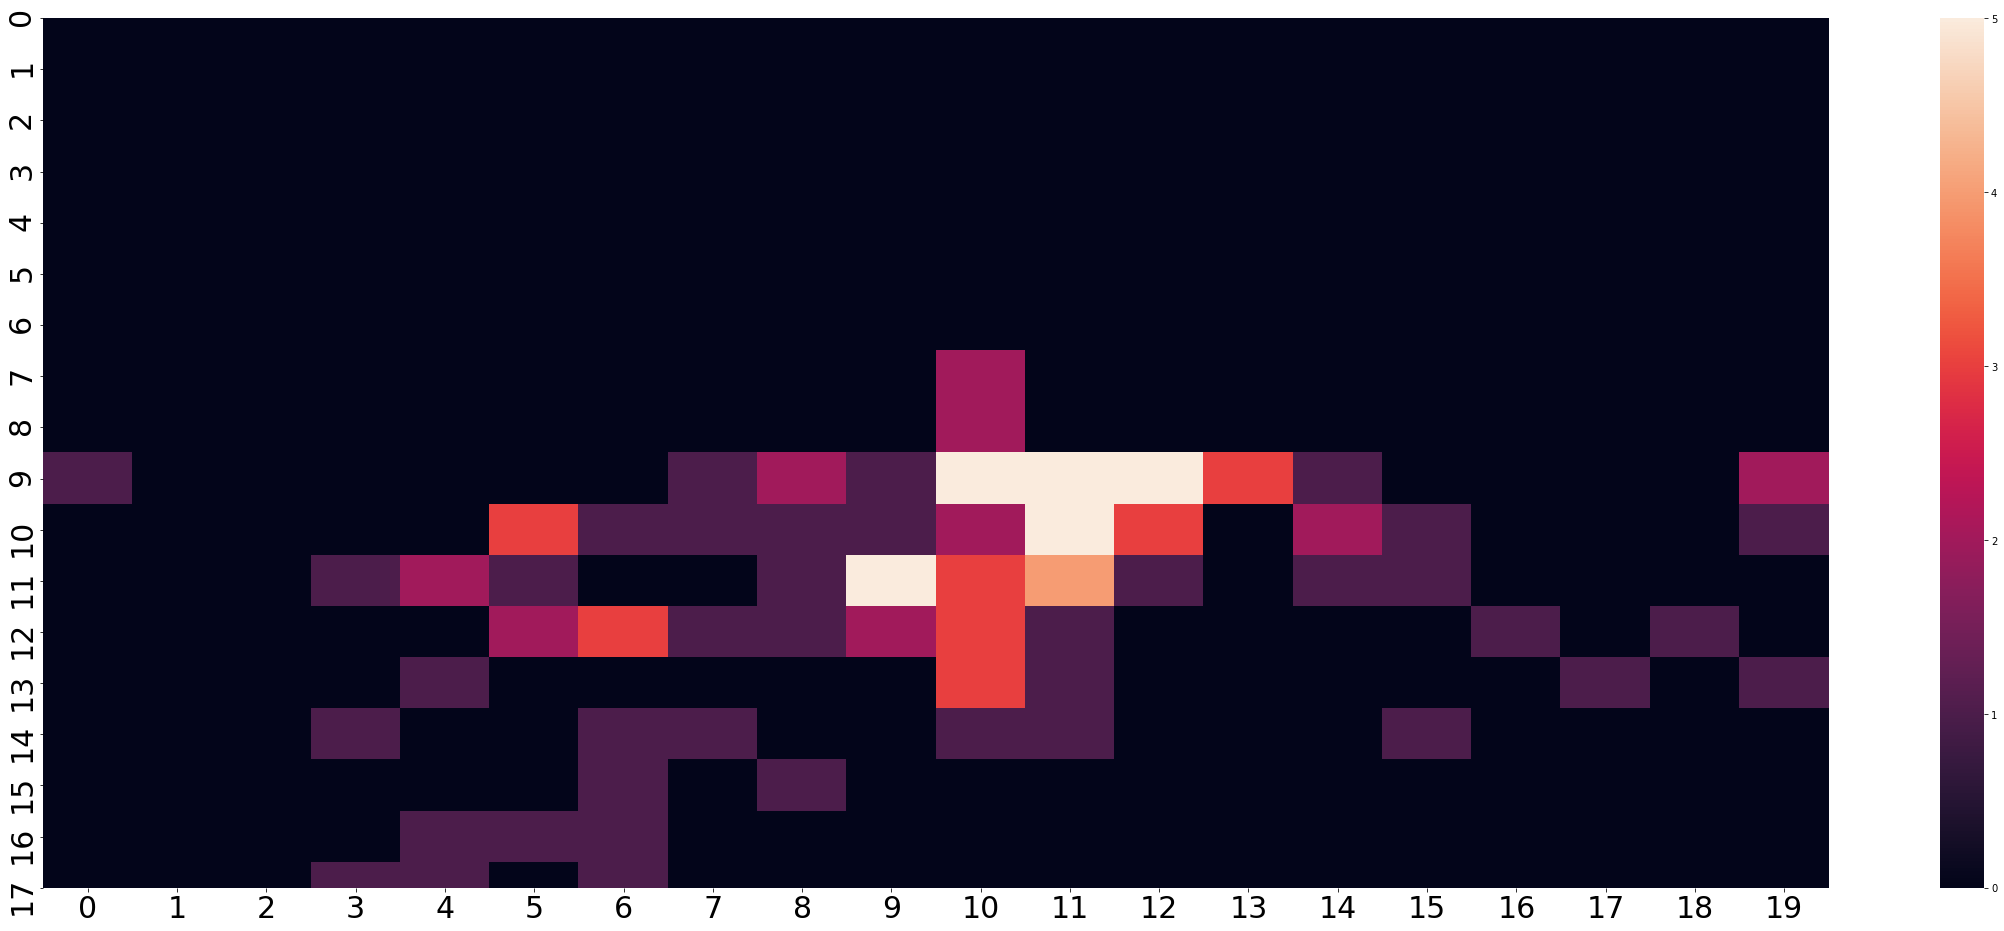

In [14]:
#凡例付きヒートマップ作成
hm_name_sample = "./tmp/hm_" + file + "_sample.jpg"
plt.figure(figsize=(40,16)) 
#fig, ax = plt.subplots(figsize=(32,16))
plt.tick_params(labelsize=30)
sns.heatmap(lst_2d,vmin=0, vmax=v_max)
#sns.heatmap(lst_2d,vmin=0, vmax=5)
plt.savefig(hm_name_sample )

In [ ]:
#合成用ヒートマップ作成
hm_name = "./tmp/hm_"+file+".jpg" #<- dirをつける
plt.figure(figsize=(32,16)) 
sns.heatmap(lst_2d,vmin=0, vmax=v_max,yticklabels=False,xticklabels=False,cbar=False)
plt.savefig(hm_name )

In [ ]:
#削除対象
#HM原画サイズ確認
filename = hm_name
img2 = cv2.imread(filename)
height = img2.shape[0]
width = img2.shape[1]
print('h:{}/w{}'.format(height,width))

In [ ]:
#HM余白削除
outfile = './tmp/hm_' + file + '_edge.jpg' # <- dirをつける
#outfile = margin_cut(hm_name,outfile)
margin_cut(hm_name,outfile)

In [ ]:
#item画像読み込み
#filename = './3453421_2048x1024.jpeg'
filename = './imgdata/' + file + '_2048x1024.jpg' # <- dirをつける
try:
    img = cv2.imread(filename)
    height = img.shape[0] # Errorを引っ掛けるためだけの仕掛
except  AttributeError:
    print('file not found. {}'.format(filename))
#cv2.imshow("color",img)
#cv2.imshow("gray",img2)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [ ]:
#削除対象
#item画像サイズ確認
height = img.shape[0]
width = img.shape[1]
print('h:{}/w{}'.format(height,width))

In [ ]:
#余白除去後HM読み込み
filename = './tmp/hm_' + file + '_edge.jpg' # <- dirをつける
try: 
    img2 = cv2.imread(filename)
    height = img2.shape[0] # Errorを引っ掛けるためだけの仕掛
except  AttributeError:
    print('file not found.')

In [ ]:
#削除対象
height = img2.shape[0]
width = img2.shape[1]
print('h:{}/w{}'.format(height,width))

In [ ]:
#削除対象
#画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
plt.show()

In [ ]:
#削除対象
#filename = 'hm_7306642_edge.jpg'
#img2 = cv2.imread(filename)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
plt.show()

In [ ]:
#削除対象
height = img2.shape[0]
width = img2.shape[1]
print(img2.shape)

In [ ]:
#サイズ調整
img2_1 = cv2.resize(img2 , (int(width*(2048.5/width)), int(height*(1024/height))))
print(img2_1.shape)
cv2.imwrite('./tmp/hm_edge.jpg', img2_1)

In [ ]:
#img2 = Image.open('hm_edge.jpg')

In [ ]:
#画像合成
blended = cv2.addWeighted(src1=img,alpha=0.6,src2=img2_1,beta=0.4,gamma=0.3)
plt.imshow(blended)

In [ ]:
#合成後画像保存
cv2.imwrite('./tmp/blended_test_' + file + '.jpg', blended) # <- dirをつける

In [ ]:
#凡例切り出し準備
im = Image.open(hm_name_sample)

In [ ]:
#plt.imshow(im)

In [ ]:
#凡例切り出し&resize
im_crop = im.crop((2230,120,2350,1030))
im_crop_rsize = im_crop.resize((100,1024))   
plt.imshow(im_crop_rsize)
im_crop_rsize.save('./tmp/colorbar_crop.jpg', quality=100) # <- dirをつける

In [ ]:
#ブランク画像作成
height = 1024
width = 2200
blank = np.zeros((height, width, 3))
blank += 255 #←全ゼロデータに255を足してホワイトにする
 
cv2.imwrite('./tmp/blank.jpg',blank) # <- dirをつける

In [ ]:
#凡例付きヒートマップ作成
img0 = cv2.imread('./tmp/blank.jpg') # <- dirをつける
img1 = cv2.imread('./tmp/blended_test_' + file + '.jpg') # <- dirをつける
img2 = cv2.imread('./tmp/colorbar_crop.jpg') # <- dirをつける

img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

base_img = img0


In [ ]:
#ヒートマップ画像貼り付け基準点設定
x_offset=0
y_offset=0

In [ ]:
#ヒートマップ画像合成
base_img[y_offset:y_offset+img1.shape[0], x_offset:x_offset+img1.shape[1]] = img1

In [ ]:
#凡例画像貼り付け基準点設定
x_offset=2050
y_offset=0

In [ ]:
#凡例画像合成
base_img[y_offset:y_offset+img2.shape[0], x_offset:x_offset+img2.shape[1]] = img2

In [ ]:
#削除対象
plt.imshow(base_img)

In [ ]:
base_img = cv2.cvtColor(base_img, cv2.COLOR_BGR2RGB)
strdate = datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S') # 制作日
cv2.imwrite('./create_data/blended_test_ver2_' + file + '_' + strdate + '.jpg',base_img) # <- dirをつける
cv2.imwrite('./create_data/original.jpg',base_img)

In [ ]:
# Create a storage client.
storage_client = google.cloud.storage.Client()

bucket_name = '/rent-heatmap/medium_items/media/' + media_id 
bucket = storage_client.get_bucket(bucket_name)

source_file_name = './create_data/original.jpg'
blob = bucket.blob(os.path.basename(source_file_name))
 
# Upload the local file to Cloud Storage.
blob.upload_from_filename(source_file_name)
 
print('File {} uploaded to {}.'.format(source_file_name,bucket))

In [ ]:
from google.cloud import storage

storage_client = storage.Client()

buckets = list(storage_client.list_buckets())
print(buckets)